<a href="https://colab.research.google.com/github/jollyoli93/KnowYourLoadExactly/blob/main/Crane_Detector_RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch

# Regression Algo

In [ ]:
from pathlib import Path
from pandas import DataFrame

In [ ]:
train_labels = "/content/drive/MyDrive/Crane-Detector/First Experiment/master_project.v6-all_img_less_aug_2cls.yolov8-obb/train/labels"
valid_labels = "/content/drive/MyDrive/Crane-Detector/First Experiment/master_project.v6-all_img_less_aug_2cls.yolov8-obb/valid/labels"

In [ ]:
coord = [p for p in Path(train_labels).glob("*")]

In [ ]:
coord[0]

PosixPath('/content/drive/MyDrive/Crane-Detector/First Experiment/master_project.v6-all_img_less_aug_2cls.yolov8-obb/train/labels/2503171220110000_jpg.rf.79079bdd006863958c8845829d666403.txt')

In [ ]:
# with open(coord[10], "r") as f:
#   coord = f.readlines()
#   get_pairs(coord)

## Get Pairs

In [ ]:
cos = [0.508, 0.16100000000000012, 0.5033333333333333, 0.16100000000000012, 0.5033333333333333, 0.1800000000000001, 0.508, 0.1800000000000001]
cos2 = [0.4, 0.14100000000000012, 0.3033333333333333, 0.14100000000000012, 0.3033333333333333, 0.1600000000000001, 0.4, 0.1600000000000001]


In [ ]:
def find_centroid(coords):
  xs = 0
  ys = 0

  for i in range(len(coords)):
    if i % 2 == 0:
      xs += coords[i]
    else:
      ys += coords[i]

  xc = xs / (len(coords)/2)
  yc = ys / (len(coords)/2)

  return [xc, yc]

In [ ]:
def get_dims(coords):
    xs = coords[::2]
    ys = coords[1::2]

    width = max(xs) - min(xs)
    height = max(ys) - min(ys)
    area = width * height
    aspect = width/height

    return [width, height, area, aspect]


In [ ]:
center = find_centroid(cos)

In [ ]:
get_dims(cos)

[0.004666666666666708,
 0.01899999999999999,
 8.86666666666674e-05,
 0.24561403508772162]

In [ ]:
from math import sqrt

def dist_between_centroids(input, target):
  x1, y1 = input
  x2, y2 = target

  dx = x1 - x2
  dy = y1 - y2

  distance = sqrt(dx**2 + dy**2)
  return distance

In [ ]:
dist_between_centroids(center, (0.4, 0.16))

0.10618707286880287

In [ ]:
def find_distance(input, target):
  input_centroid = find_centroid(input)
  target_centroid = find_centroid(target)

  distance = dist_between_centroids(input_centroid, target_centroid)
  return distance


In [ ]:
find_distance(cos, cos2)

0.15529327094243334

In [ ]:
def get_pairs(coords):
  coord_split = [[float(x) for x in line.strip().split()] for line in coords if line.strip()]
  class_0_boxes = [d for d in coord_split if d[0] == 0]
  class_1_boxes = [d for d in coord_split if d[0] == 1]

  pairs = dict({'x':[], 'y':[]})
  used_0 = set()

  for i, box1 in enumerate(class_1_boxes):
      x1 = float(box1[1])
      closest = None
      min_dist = float("inf")
      closest_idx = -1

      for j, box0 in enumerate(class_0_boxes):
          if j not in used_0:
              x0 = float(box0[1])
              dist = abs(x1 - x0)
              if dist < min_dist:
                  min_dist = dist
                  closest = box0
                  closest_idx = j

      if closest:
          # distance = find_distance(closest[1:], box1[1:])
          dims = get_dims(closest[1:])
          centre = find_centroid(closest[1:])

          # pairs['x'].append(closest[1:])
          # pairs['x'].append(closest[1:] + [distance])
          pairs['x'].append(closest[1:] + dims + centre ) # derived dimensions

          # pairs['y'].append(box1[1:]) # standard
          pairs['y'].append(find_centroid(box1[1:])) #x, y,

          # print(f"{closest[1:]}, y: {box1[1:]} ")

          used_0.add(closest_idx)

  return pairs


In [ ]:
print(get_pairs(open("/content/drive/MyDrive/Crane-Detector/First Experiment/master_project.v6-all_img_less_aug_2cls.yolov8-obb/train/labels/2502070850004013_jpg.rf.a5b26a94f09ab41e915df9c6ea02ee64.txt").readlines()))

{'x': [[0.508, 0.16100000000000012, 0.5033333333333333, 0.16100000000000012, 0.5033333333333333, 0.1800000000000001, 0.508, 0.1800000000000001, 0.004666666666666708, 0.01899999999999999, 8.86666666666674e-05, 0.24561403508772162, 0.5056666666666667, 0.1705000000000001], [0.10666666666666667, 0.020000000000000018, 0.09666666666666666, 0.020000000000000014, 0.09666666666666666, 0.03500000000000002, 0.10666666666666667, 0.03500000000000002, 0.010000000000000009, 0.015000000000000003, 0.00015000000000000015, 0.6666666666666671, 0.10166666666666667, 0.027500000000000017]], 'y': [[0.5043333333333333, 0.23050000000000012], [0.11699999999999999, 0.11050000000000001]]}


## Create Dataset

In [ ]:
from torch.utils.data import Dataset

class YoloLabelsDataset(Dataset):
    def __init__(self, label_dir):
        self.label_dir = label_dir
        self.labels = list(Path(label_dir).glob("*.txt"))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]

        with open(label, "r") as f:
          coord_file = f.readlines()

        if len(coord_file) > 1:
          pairs = get_pairs(coord_file)
          if pairs is None or 'x' not in pairs or 'y' not in pairs:
            return None
          return pairs

In [ ]:
train_ds = YoloLabelsDataset(train_labels)
valid_ds = YoloLabelsDataset(valid_labels)

In [ ]:
test_data = train_ds.__getitem__(15)

In [ ]:
test_valid_data = valid_ds.__getitem__(6)

## Collate Function

In [ ]:
import torch

def collate_pairs(batch):
    batch = [item for item in batch if item is not None]

    xs = []
    ys = []

    for item in batch:
        for x_coords, y_coords in zip(item['x'], item['y']):
            xs.append(torch.tensor(x_coords, dtype=torch.float32))
            ys.append(torch.tensor(y_coords, dtype=torch.float32))

    x_tens = torch.stack(xs)
    y_tens = torch.stack(ys)

    return x_tens, y_tens



In [ ]:
collate_pairs([test_valid_data])

(tensor([[0.3133, 0.3300, 0.2880, 0.3300, 0.2880, 0.4140, 0.3133, 0.4140, 0.0253,
          0.0840, 0.0021, 0.3016, 0.3007, 0.3720],
         [0.9433, 0.4050, 0.8827, 0.4050, 0.8827, 0.5160, 0.9433, 0.5160, 0.0607,
          0.1110, 0.0067, 0.5465, 0.9130, 0.4605]]),
 tensor([[0.3145, 0.6077],
         [0.8623, 0.8059]]))

## Create Dataloaders

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=64, collate_fn=collate_pairs, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=64, collate_fn=collate_pairs, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))

KeyboardInterrupt: 

In [ ]:
x, y = batch

In [ ]:
len(train_dataloader)

24

## Define Model

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, in_feat, out_feat) -> None:
        super().__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_feat, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, out_feat),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
linearModel = LinearRegression(14, 2)

In [ ]:
optimizer = torch.optim.SGD(linearModel.parameters(), lr=0.1, momentum=0.9)
loss = torch.nn.MSELoss()

In [ ]:
def train_epoch(dataloader, optim, loss_fn, model):
  for i, batch in enumerate(dataloader):
    x,y = batch
    predict = model(x)
    loss = loss_fn(predict, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
  return loss.item()

In [ ]:
# train_epoch(train_dataloader, optimizer, loss, linearModel)

In [ ]:
# len(valid_dataloader.dataset)

In [ ]:
from sklearn.metrics import r2_score

@torch.no_grad()
def validate_epoch(dataloader, model, loss_fn):
  total_loss = 0
  all_targets = []
  all_preds = []

  for i, batch in enumerate(dataloader):
    x, y = batch
    predict = model(x)
    print(f"y {y[0]} - predict {predict[0]}")
    loss = loss_fn(predict, y)
    total_loss += loss.item()

    all_preds.append(predict.cpu())
    all_targets.append(y.cpu())

  all_preds = torch.cat(all_preds, dim=0).numpy()
  all_targets = torch.cat(all_targets, dim=0).numpy()

  # Compute r2
  r2 = r2_score(all_targets, all_preds)
  avg_loss = total_loss / len(dataloader.dataset)

  return avg_loss, r2


In [ ]:
# validate_epoch(valid_dataloader, linearModel, loss)

In [ ]:
def fit(epochs):
  train_losses = []
  valid_losses = []
  rsqrd = []

  for i in range(1, epochs+1):
    train_loss = train_epoch(train_dataloader, optimizer, loss, linearModel)
    valid_loss = validate_epoch(valid_dataloader, linearModel, loss)
    mse, r2 = valid_loss

    train_losses.append(train_loss)
    valid_losses.append(mse)
    rsqrd.append(r2)

    print(f"Epoch {i}- Train Loss: {train_loss} - Valid Loss: {mse} -  R2 Loss: {r2}")
  return train_losses, valid_losses, rsqrd

In [ ]:
metrics = fit(1)

y tensor([0.5163, 0.1100]) - predict tensor([0.5417, 0.4534])
y tensor([0.7293, 0.4356]) - predict tensor([0.5495, 0.4589])
Epoch 1- Train Loss: 0.03567507490515709 - Valid Loss: 0.0007218577712774277 -  R2 Loss: 0.09018003940582275


## Try now with different layers and different number of hidden activations

### Plot graphs


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# train_losses, valid_losses, rsqrd = metrics
# epochs = 10

# plt.plot(range(1, epochs+1), train_losses)
# plt.plot(range(1, epochs+1), valid_losses)
# plt.show()
# plt.plot(range(1, epochs+1), rsqrd)
# plt.show()

## Extra hidden Layers

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, in_feat, out_feat, hidden) -> None:
        super().__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_feat, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_feat),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
import torch
from sklearn.metrics import r2_score

class CoordCropModel:
    def __init__(self, model, opt_class, loss, dataloaders, lr=0.1, device=None, momentum=0.9, weight_decay=0.00001) -> None:
        self.model = model
        self.loss_fn = loss
        self.train_dl = dataloaders['train']
        self.valid_dl = dataloaders['valid']
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.opt = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay) #use for SGB
        # self.opt = opt_class(self.model.parameters()) #use for adam

        self.train_loss = []
        self.valid_loss = []
        self.r2 = []
        self.epochs = 0

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0.0

        for x, y in self.train_dl:
            x, y = x.to(self.device), y.to(self.device)

            predict = self.model(x)
            loss = self.loss_fn(predict, y)

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            epoch_loss += loss.item()

        self.train_loss.append(epoch_loss / len(self.train_dl))

    @torch.no_grad()
    def validate_epoch(self):
        self.model.eval()
        total_loss = 0.0
        all_targets, all_preds = [], []

        for x, y in self.valid_dl:
            x, y = x.to(self.device), y.to(self.device)
            predict = self.model(x)
            loss = self.loss_fn(predict, y)
            total_loss += loss.item()

            all_preds.append(predict.cpu())
            all_targets.append(y.cpu())

        all_preds = torch.cat(all_preds, dim=0).numpy()
        all_targets = torch.cat(all_targets, dim=0).numpy()

        self.r2.append(r2_score(all_targets, all_preds))
        self.valid_loss.append(total_loss / len(self.valid_dl))

    def fit(self, epochs):
      self.epochs += epochs

      for i in range(1, epochs+1):
          self.train_epoch()
          self.validate_epoch()

          print(f"Epoch {i} - "
                f"Train Loss: {self.train_loss[-1]:.4f} - "
                f"Valid Loss: {self.valid_loss[-1]:.4f} - "
                f"R2: {self.r2[-1]:.4f}")

    def get_loss_graph(self):
      plt.plot(range(1, self.epochs+1), self.train_loss)
      plt.plot(range(1, self.epochs+1), self.valid_loss)
      plt.show()

    def get_r2_graph(self):
      plt.plot(range(1, self.epochs+1), self.r2)
      plt.show()

    def metrics(self):
      metrics = self.train_loss, self.valid_loss, self.r2
      return metrics

In [ ]:
from torch.utils.data import DataLoader

seed = 42

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(
    train_ds,
    batch_size=64,
    collate_fn=collate_pairs,
    shuffle=True,
    generator=g
)

valid_dataloader = DataLoader(
    valid_ds,
    batch_size=64,
    collate_fn=collate_pairs,
    shuffle=True,
    generator=g
)

In [ ]:
dataloader_dict = {'train': train_dataloader, 'valid': valid_dataloader}

In [ ]:
loss = torch.nn.MSELoss()
opt = torch.optim.Adam
Linear512 = LinearRegression(14, 2, 512) # 14 features output x,y


In [ ]:
cropModel1 = CoordCropModel(model=Linear512, loss=loss, opt_class=opt, dataloaders=dataloader_dict, lr=0.1, weight_decay=0)
# train epochs to 100 at 128 hidden activations and it got to around 0.84 but had more in the tank
# trained epochs to around 50 at 512 activations and got to around 0.886, the valid loss was flucuating but not going terrible. Need to add regularization.
# trained epochs to around 30 at 512 activations and 0.01 to 0.0001 but valid loss and R2 weren't stable/

# 14 features, 2 outputs, 512 hidden activations with 0.0001 weight decay. Seems stable some fluctuation on valid loss but still decreasing
# Epoch 100 - Train Loss: 0.0039 - Valid Loss: 0.0043 - R2: 0.8780 --- Best 0.8849 at 98 epochs

#Final Run - 14 features, 2 outputs, 512 hidden activations, momentum = 0.9, weight_decay =0, SGD, MSE
# Epoch 50 - Train Loss: 0.0040 - Valid Loss: 0.0050 - R2: 0.8864

In [ ]:
cropModel1.fit(50)

Epoch 1 - Train Loss: 0.0292 - Valid Loss: 0.0291 - R2: 0.2794
Epoch 2 - Train Loss: 0.0184 - Valid Loss: 0.0158 - R2: 0.5906
Epoch 3 - Train Loss: 0.0107 - Valid Loss: 0.0099 - R2: 0.7620
Epoch 4 - Train Loss: 0.0077 - Valid Loss: 0.0086 - R2: 0.8120
Epoch 5 - Train Loss: 0.0067 - Valid Loss: 0.0069 - R2: 0.8240
Epoch 6 - Train Loss: 0.0063 - Valid Loss: 0.0067 - R2: 0.8234
Epoch 7 - Train Loss: 0.0060 - Valid Loss: 0.0061 - R2: 0.8333
Epoch 8 - Train Loss: 0.0058 - Valid Loss: 0.0074 - R2: 0.8422
Epoch 9 - Train Loss: 0.0056 - Valid Loss: 0.0070 - R2: 0.8355
Epoch 10 - Train Loss: 0.0055 - Valid Loss: 0.0058 - R2: 0.8434
Epoch 11 - Train Loss: 0.0054 - Valid Loss: 0.0069 - R2: 0.8515
Epoch 12 - Train Loss: 0.0053 - Valid Loss: 0.0062 - R2: 0.8542
Epoch 13 - Train Loss: 0.0052 - Valid Loss: 0.0066 - R2: 0.8525
Epoch 14 - Train Loss: 0.0052 - Valid Loss: 0.0063 - R2: 0.8582
Epoch 15 - Train Loss: 0.0051 - Valid Loss: 0.0056 - R2: 0.8557
Epoch 16 - Train Loss: 0.0050 - Valid Loss: 0.005

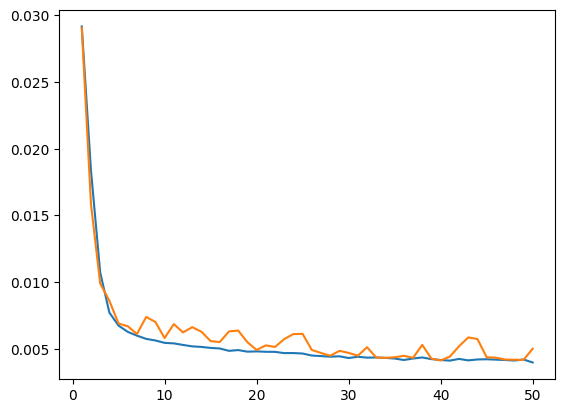

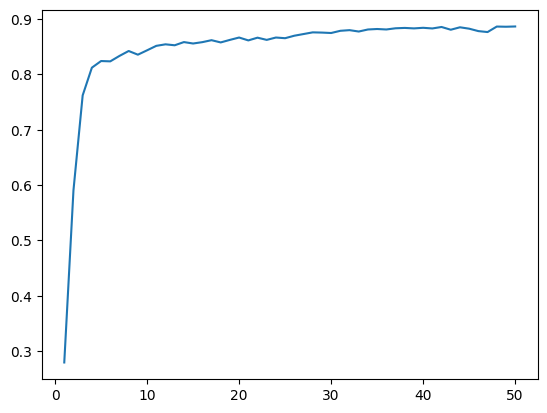

In [ ]:
cropModel1.get_loss_graph(); cropModel1.get_r2_graph()

In [ ]:
%cd /content/drive/MyDrive/Crane-Detector/LoadRegressionModel

/content/drive/MyDrive/Crane-Detector/LoadRegressionModel


In [ ]:
!ls

LoadRegression	LoadRegressionCenter  LoadRegressionDims  LoadRegressionDist


In [ ]:
torch.save(cropModel1.model.state_dict(), "/content/drive/MyDrive/Crane-Detector/LoadRegressionModel/LoadRegressionDims")

### ADAM Opt

In [ ]:
Linear512 = LinearRegression(8, 8, 512)
cropModelAdam = CoordCropModel(model=Linear512, loss=loss, opt_class=torch.optim.Adam, dataloaders=dataloader_dict, lr=0)
cropModelAdam.fit(100) #needs training longer use GPU for 100 epochs

In [ ]:
cropModelAdam.get_loss_graph(); cropModelAdam.get_r2_graph()

In [ ]:
loss = torch.nn.MSELoss()
Linear512 = LinearRegression(8, 8, 512)

cropModel1 = CoordCropModel(model=Linear512, loss=loss, dataloaders=dataloader_dict, lr=0.1, momentum=0)

In [ ]:
Linear512 = LinearRegression(8, 8, 512)
cropModel2 = CoordCropModel(model=Linear512, loss=loss, dataloaders=dataloader_dict, lr=0.05)

In [ ]:
cropModel2.fit(15) # R2 0.76 starts to overfit

In [ ]:
cropModel2.get_loss_graph(); cropModel2.get_r2_graph()

In [ ]:
Linear512 = LinearRegression(8, 8, 1000)
cropModel3 = CoordCropModel(model=Linear512, loss=loss, dataloaders=dataloader_dict, lr=0.1)

In [ ]:
cropModel3.fit(15) #0.8038

## Create deeper network

In [ ]:
class LinearRegressionDeepx2(torch.nn.Module):
    def __init__(self, in_feat, out_feat, hidden) -> None:
        super().__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_feat, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_feat),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
model = LinearRegressionDeepx2(8,8, 512) # Not as good as more shallow models
cropModelDeep = CoordCropModel(model=model, loss=loss, dataloaders=dataloader_dict, lr=0.1)

In [ ]:
# cropModelDeep.fit(15)